# Adapter Faseforskyvning

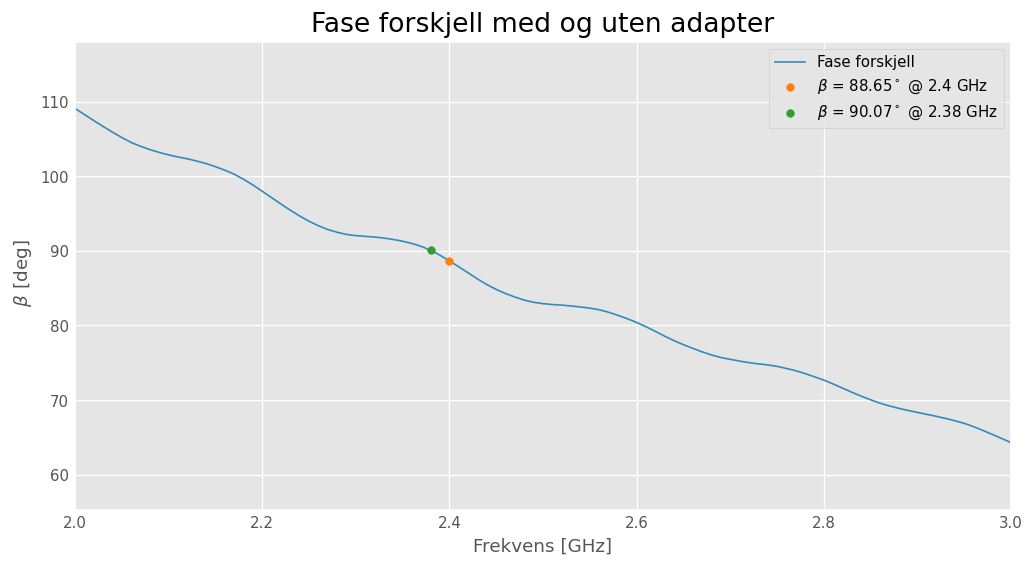

In [219]:
import skrf as rf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_paths = ['S_Parameter_lab/S11_phase_ref.dat', 'S_Parameter_lab/S11_phase_adapter.dat']
columns = ['Frequency [MHz]', 'Mag', 'Phase [deg]']

ref = pd.read_csv(file_paths[0], sep=r"\s+", header=None, names=columns, decimal=',')
adapter = pd.read_csv(file_paths[1], sep=r"\s+", header=None, names=columns, decimal=',')

phase_diff = pd.DataFrame()
phase_diff['Frequency [GHz]'] = ref[ref['Frequency [MHz]']>=2000]['Frequency [MHz]'] / 1000
phase_diff['Phase [deg]'] = (adapter[adapter['Frequency [MHz]']>=2000]['Phase [deg]'] - ref[ref['Frequency [MHz]']>=1500]['Phase [deg]'])/2

# Calculate the phase difference at 2.4 GHz
phase_diff_24 = phase_diff[phase_diff['Frequency [GHz]'] == 2.4]['Phase [deg]']

# Calculate the frequency where the phase difference is closest to 90
phase_diff['Phase diff from 90'] = np.abs(phase_diff['Phase [deg]'] - 90)
phase_diff_90 = phase_diff[phase_diff['Phase diff from 90'] == phase_diff['Phase diff from 90'].min()]


# Plot the data
fig = plt.figure(figsize=(10, 5))
plt.plot(phase_diff['Frequency [GHz]'], phase_diff['Phase [deg]'], label='Fase forskjell')
plt.scatter(2.4, phase_diff_24, label=rf'$\beta$ = {phase_diff_24.values[0]}$^\circ$ @ 2.4 GHz', zorder=5, s=20, color='tab:orange')
plt.scatter(phase_diff_90['Frequency [GHz]'], phase_diff_90['Phase [deg]'], label=rf'$\beta$ = {phase_diff_90["Phase [deg]"].values[0]:.2f}$^\circ$ @ {phase_diff_90["Frequency [GHz]"].values[0]} GHz', zorder=5, s=20, color='tab:green')
plt.xlabel('Frekvens [GHz]')
plt.ylabel(r' $\beta$ [deg]')
plt.title('Fase forskjell med og uten adapter')
plt.legend()
plt.show()

# S11 dB

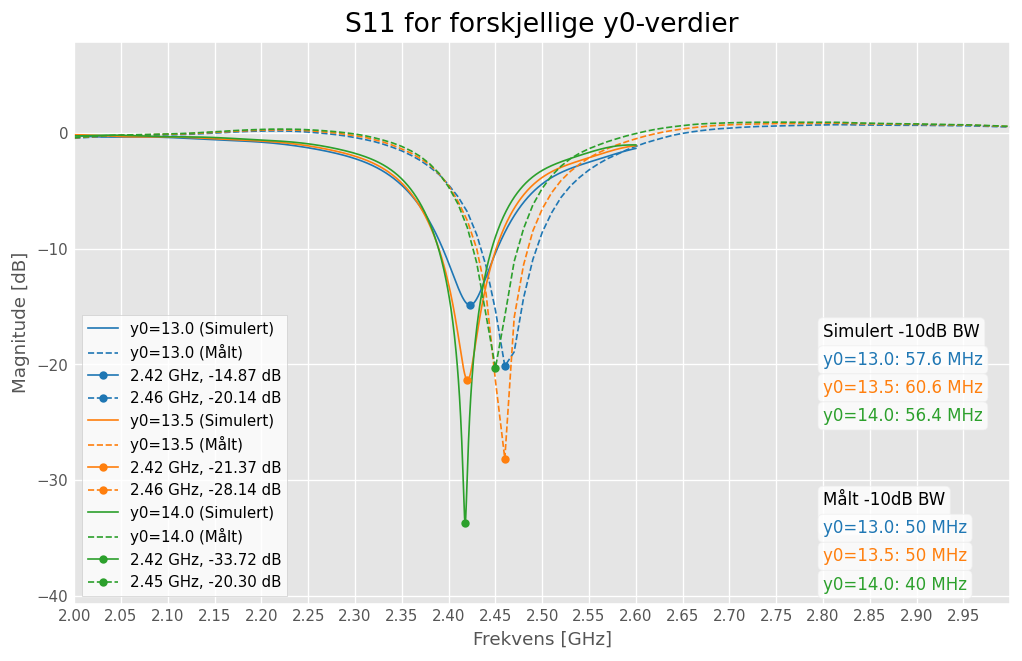

In [231]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
file_path = 'CST_Data/S11_Sweep.txt'

# Define the line ranges for each y0 value
ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Initialize empty DataFrame to store all data
df = pd.DataFrame()

# Read the first file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', names=["Frequency / GHz", f"{y0}"])
    if df.empty:
        df = data
    else:
        df = pd.merge(df, data, on="Frequency / GHz")

# Plot the data from the first file
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }


cols = ["Frequency [MHz]", "Mag", "Phase"]
y0_values = ['y0=13.0', 'y0=13.5', 'y0=14.0']

measured_files = ['S_Parameter_lab/S11_y13.s1p', 'S_Parameter_lab/S11_y135.s1p', 'S_Parameter_lab/S11_y14.s1p']

y0_13_meas = pd.read_csv(measured_files[0], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')
y0_135_meas = pd.read_csv(measured_files[1], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')
y0_14_meas = pd.read_csv(measured_files[2], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')

# Turn magnitude into dB
y0_13_meas['Mag'] = 20*np.log10(y0_13_meas['Mag'])
y0_135_meas['Mag'] = 20*np.log10(y0_135_meas['Mag'])
y0_14_meas['Mag'] = 20*np.log10(y0_14_meas['Mag'])

y0_meas = {y0_values[0]: y0_13_meas[y0_13_meas['Frequency [MHz]']>=2000],
           y0_values[1]: y0_135_meas[y0_135_meas['Frequency [MHz]']>=2000],
           y0_values[2]: y0_14_meas[y0_14_meas['Frequency [MHz]']>=2000]}

fig, ax = plt.subplots(figsize=(10, 6))

bandwidths = {}
bandwidths_meas = {}

for column in df.columns[1:]:
    ax.plot(df["Frequency / GHz"], df[column], label=column + ' (Simulert)', color=colors[column])
    ax.plot(y0_meas[column]['Frequency [MHz]']/1000, y0_meas[column]['Mag'], label=column + ' (Målt)', color=colors[column], linestyle='dashed')
    
    # Find the minimum value
    min_value = df[column].min()
    min_index = df[column].idxmin()
    min_frequency = df["Frequency / GHz"][min_index]

    min_value_meas = y0_meas[column]['Mag'].min()
    min_index_meas = y0_meas[column]['Mag'].idxmin()
    min_frequency_meas = y0_meas[column]['Frequency [MHz]'][min_index_meas]/1000

    # Plot the minimum point
    ax.plot(min_frequency, min_value, 'o', color=colors[column], label=f'{min_frequency:.2f} GHz, {min_value:.2f} dB', linestyle='solid', zorder=5, markersize=4)
    ax.plot(min_frequency_meas, min_value_meas, 'o', color=colors[column], label=f'{min_frequency_meas:.2f} GHz, {min_value_meas:.2f} dB', linestyle='dashed', zorder=5, markersize=4)

    # Calculate the -10 db bandwidth
    bandwidth = df[df[column] <= - 10]
    bandwidth = (bandwidth['Frequency / GHz'].max() - bandwidth['Frequency / GHz'].min()) * 1000

    bandwidth_meas = y0_meas[column][y0_meas[column]['Mag'] <= - 10]
    bandwidth_meas = bandwidth_meas['Frequency [MHz]'].max() - bandwidth_meas['Frequency [MHz]'].min()

    bandwidths[column] = bandwidth
    bandwidths_meas[column] = bandwidth_meas

# Annotate the -10 dB bandwidth for each y0 value in the plot in a colored box in the corner with the corresponding color around a white background
textstr_sim = 'Simulert -10dB BW\n'
textstr_meas = 'Målt -10dB BW\n'

props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# Annotate simulated bandwidths with corresponding colors
ax.text(0.80, 0.5, textstr_sim, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, color='black')
for i, (key, value) in enumerate(bandwidths.items()):
    ax.text(0.80, 0.45 - i*0.05, f'{key}: {value:.1f} MHz', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, color=colors[key])

# Annotate measured bandwidths with corresponding colors
ax.text(0.80, 0.2, textstr_meas, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, color='black')
for i, (key, value) in enumerate(bandwidths_meas.items()):
    ax.text(0.80, 0.15 - i*0.05, f'{key}: {value:.0f} MHz', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, color=colors[key])




# Plot formatting
ax.set_title('S11 for forskjellige y0-verdier')
ax.set_xlabel('Frekvens [GHz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_xticks(np.arange(2, 3, 0.05))
ax.legend(facecolor='white')
ax.grid(True)

# Show the plot
plt.show()

# S11 Smith Chart

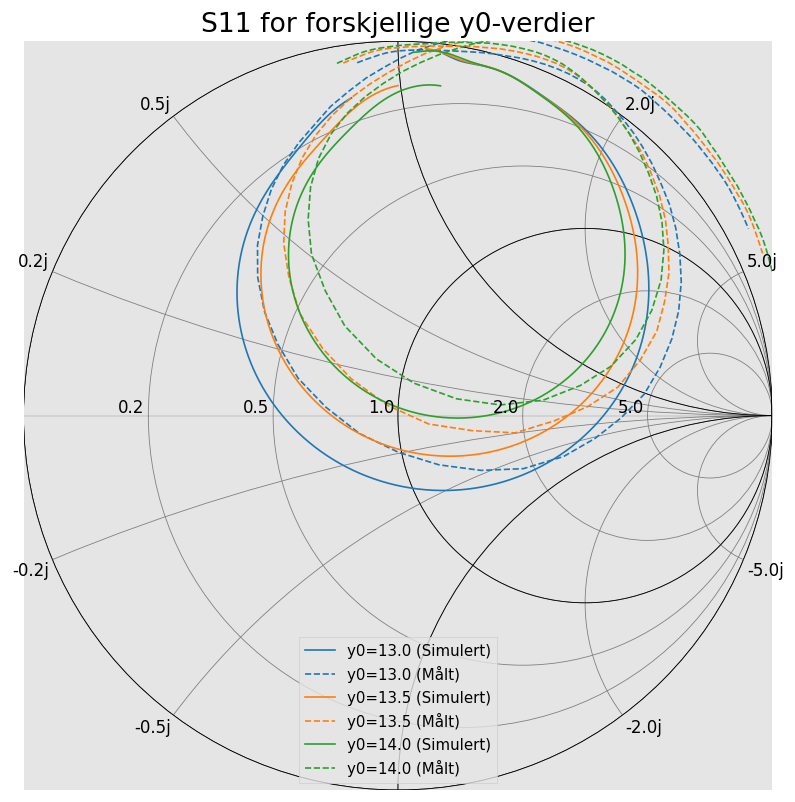

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np

file_path = 'CST_Data/S11_Sweep_Smith.txt'

ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

cols = ["Frequency [MHz]", "Mag", "Phase"]
y0_values = ['y0=13.0', 'y0=13.5', 'y0=14.0']

measured_files = ['S_Parameter_lab/S11_y13.s1p', 'S_Parameter_lab/S11_y135.s1p', 'S_Parameter_lab/S11_y14.s1p']

y0_13_meas = pd.read_csv(measured_files[0], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')
y0_135_meas = pd.read_csv(measured_files[1], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')
y0_14_meas = pd.read_csv(measured_files[2], skiprows=4, delimiter=r'\s+', names=cols, decimal=',')

# Rotate the phase
phase_rotation = 135
y0_13_meas['Phase'] = y0_13_meas['Phase'] + phase_rotation
y0_135_meas['Phase'] = y0_135_meas['Phase'] + phase_rotation
y0_14_meas['Phase'] = y0_14_meas['Phase'] + phase_rotation

y0_meas = {y0_values[0]: y0_13_meas[y0_13_meas['Frequency [MHz]']>=2000],
           y0_values[1]: y0_135_meas[y0_135_meas['Frequency [MHz]']>=2000],
           y0_values[2]: y0_14_meas[y0_14_meas['Frequency [MHz]']>=2000]}

# Dictionary to store Network objects
networks = {}
ref_mags = {}

# Read the file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', 
                       names=["Frequency", "Mag", "Phase", "Ref Mag", "Ref Phase"])
    
    frequency = data["Frequency"].values * 1e9  # Convert GHz to Hz
    s11_mag = data["Mag"].values
    s11_phase = data["Phase"].values
    
    # Compute complex reflection coefficient (Gamma)
    s11_complex = s11_mag * np.exp(1j * np.deg2rad(s11_phase))
    
    # Store network
    networks[y0] = rf.Network(frequency=frequency, s=s11_complex)
    ref_mags[y0] = data["Ref Mag"].values[0]

# Define colors
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }

# Create figure and plot Smith chart
fig, ax = plt.subplots(figsize=(8, 8))

rf.plotting.smith(ax=ax, draw_labels=True, ref_imm=1, chart_type='z')

for y0, network in networks.items():
    # Plot S11
    network.plot_s_smith(ax=ax, label=f"{y0} (Simulert)", color=colors[y0])
    
     # Plot measured data with dashed lines
    ax.plot(y0_meas[y0]['Mag'] * np.cos(np.deg2rad(y0_meas[y0]['Phase'])), 
            y0_meas[y0]['Mag'] * np.sin(np.deg2rad(y0_meas[y0]['Phase'])), 
            linestyle='dashed', color=colors[y0], label=f"{y0} (Målt)")

# Add title and legend
ax.set_title('S11 for forskjellige y0-verdier')
ax.legend(loc='lower center')

# Set axis limits and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Add grid and ticks
ax.grid(True, which='both')
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, 
               colors='black', grid_color='gray', grid_alpha=0.5)

# Show the plot
plt.show()


# Farfield Plots

## Data innlastning

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Les inn dataen
file_paths_standard = {
    '2.0 GHz': 'CST_Data/2_0GHz3D.txt',
    '2.4 GHz': 'CST_Data/2_4GHz3D.txt',
    '2.6 GHz': 'CST_Data/2_6GHz3D.txt'
}

file_paths_array = {
    '2.4 GHz Array Beta 0': 'CST_Data/2_4GHz3D_Array_Beta0.txt',
    '2.4 GHz Array Beta 90': 'CST_Data/2_4GHz3D_Array_Beta90.txt'
}

columns = ["Theta [deg.]", "Phi [deg.]", "Abs(Dir.)[dBi]", "Abs(Cross)[dBi]", "Phase(Cross)[deg.]", 
           "Abs(Copol)[dBi]", "Phase(Copol)[deg.]", "Ax.Ratio[dB]"]

datasets_standard = {freq: pd.read_csv(path, skiprows=2, names=columns, sep=r"\s+") for freq, path in file_paths_standard.items()}
datasets_array = {freq: pd.read_csv(path, skiprows=2, names=columns, sep=r"\s+") for freq, path in file_paths_array.items()}

## Strålingsdiagram (Polar)

### Standard

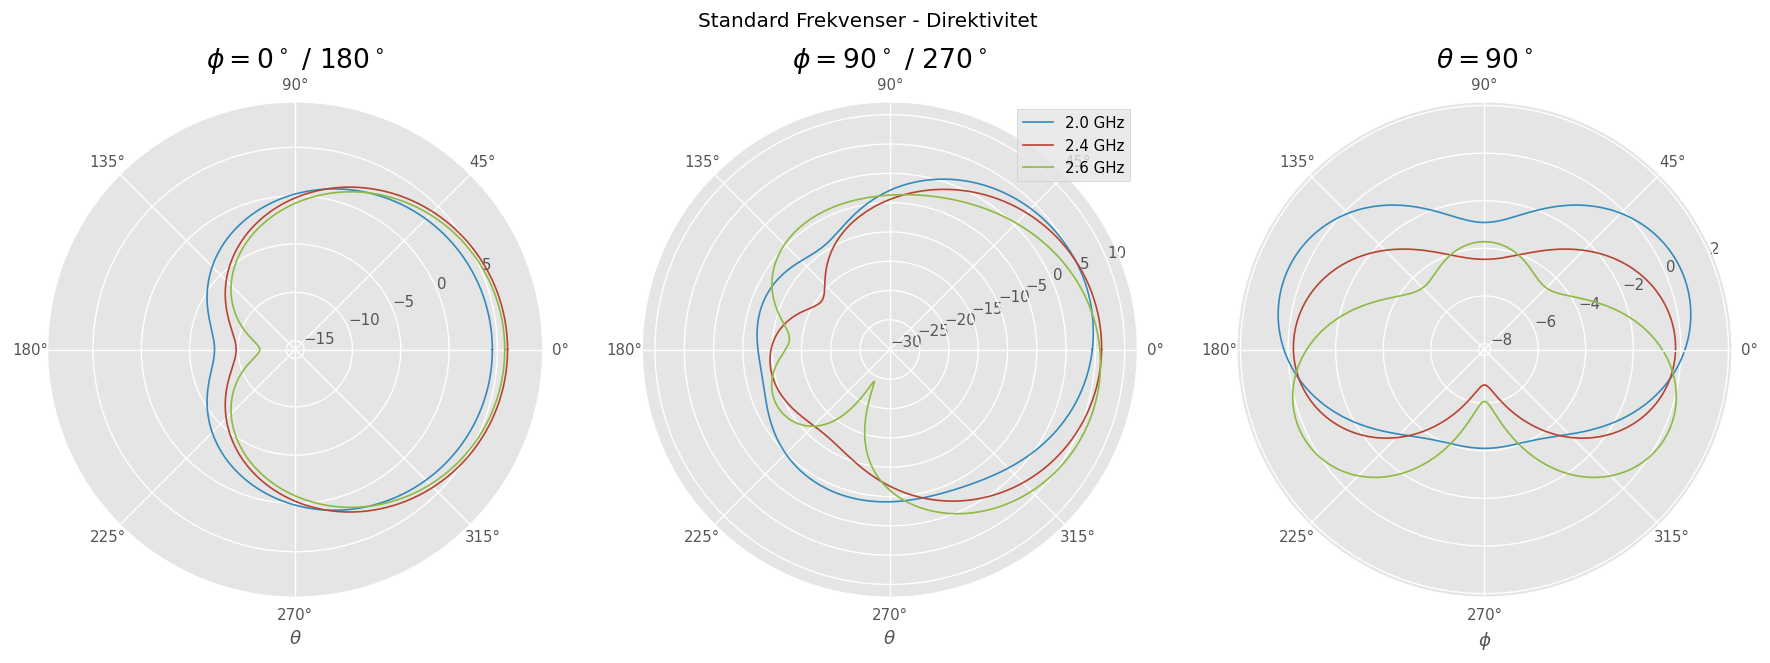

In [223]:
# Plotting av polar-diagrammer for standard-frekvenser
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(18, 6))

for freq, data in datasets_standard.items():
    # Del opp i E- og H-plan
    e_plane1 = data[data["Phi [deg.]"].isin([0])]
    e_plane2 = data[data["Phi [deg.]"].isin([180])].copy()
    e_plane2["Theta [deg.]"] = 360 - e_plane2["Theta [deg.]"]
    e_plane = pd.concat([e_plane1, e_plane2])

    h_plane1 = data[data["Phi [deg.]"].isin([90])]
    h_plane2 = data[data["Phi [deg.]"].isin([270])].copy()
    h_plane2["Theta [deg.]"] = 360 - h_plane2["Theta [deg.]"]
    h_plane = pd.concat([h_plane1, h_plane2])
    
    # Sorter for å unngå streker mellom ikke-sammenhengende punkter
    e_plane = e_plane.sort_values(by="Theta [deg.]")
    h_plane = h_plane.sort_values(by="Theta [deg.]")
    e2_plane = data[data["Theta [deg.]"].isin([90])]

    # E-plan
    ax[0].plot(np.radians(e_plane["Theta [deg.]"].values), e_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[0].set_title(r"$\phi = 0^\circ$ / $180^\circ$")
    ax[0].set_xlabel(r"$\theta$")

    # H-plan
    ax[1].plot(np.radians(h_plane["Theta [deg.]"].values), h_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[1].set_title(r"$\phi = 90^\circ$ / $270^\circ$")
    ax[1].set_xlabel(r"$\theta$")

    ax[2].plot(np.radians(e2_plane["Phi [deg.]"].values), e2_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[2].set_title(r"$\theta = 90^\circ$")
    ax[2].set_xlabel(r"$\phi$")
    

ax[1].legend(loc='best')
plt.suptitle("Standard Frekvenser - Direktivitet")
plt.show()

### Array

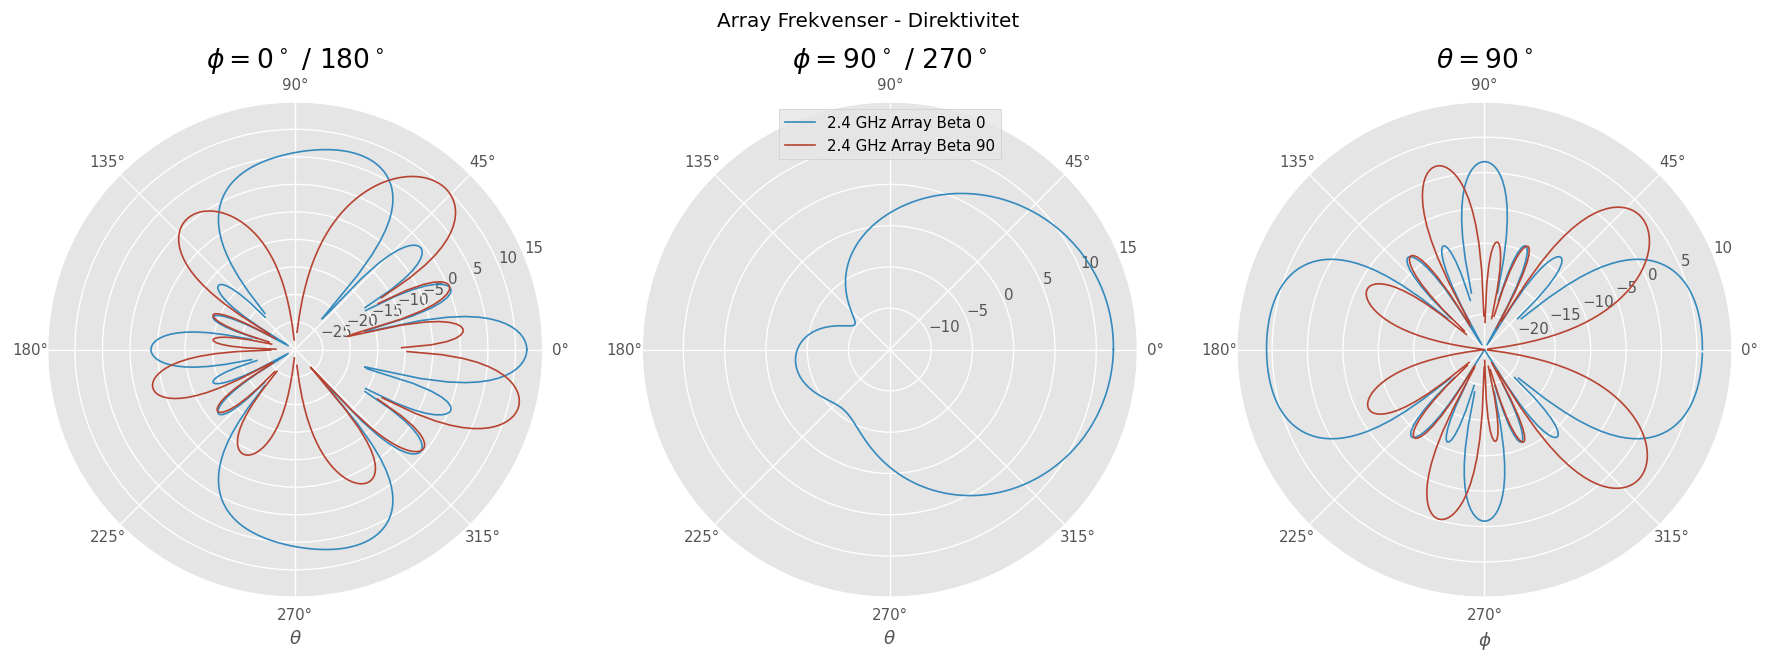

In [224]:
# Plotting av polar-diagrammer for array-frekvenser
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(18, 6))

for freq, data in datasets_array.items():
    # Del opp i E- og H-plan
    e_plane1 = data[data["Phi [deg.]"].isin([0])]
    e_plane2 = data[data["Phi [deg.]"].isin([180])].copy()
    e_plane2["Theta [deg.]"] = 360 - e_plane2["Theta [deg.]"]
    e_plane = pd.concat([e_plane1, e_plane2])

    h_plane1 = data[data["Phi [deg.]"].isin([90])]
    h_plane2 = data[data["Phi [deg.]"].isin([270])].copy()
    h_plane2["Theta [deg.]"] = 360 - h_plane2["Theta [deg.]"]
    h_plane = pd.concat([h_plane1, h_plane2])
    
    # Sorter for å unngå streker mellom ikke-sammenhengende punkter
    e_plane = e_plane.sort_values(by="Theta [deg.]")
    h_plane = h_plane.sort_values(by="Theta [deg.]")
    e2_plane = data[data["Theta [deg.]"].isin([90])]

    # E-plan
    ax[0].plot(np.radians(e_plane["Theta [deg.]"].values), e_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[0].set_title(r"$\phi = 0^\circ$ / $180^\circ$")
    ax[0].set_xlabel(r"$\theta$")
    ax[0].set_ylim(-30, 15)  # Tilpass r-aksen her

    # H-plan
    ax[1].plot(np.radians(h_plane["Theta [deg.]"].values), h_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[1].set_title(r"$\phi = 90^\circ$ / $270^\circ$")
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_ylim(-15, 15)  # Tilpass r-aksen her

    ax[2].plot(np.radians(e2_plane["Phi [deg.]"].values), e2_plane["Abs(Dir.)[dBi]"].values, label=f"{freq}")
    ax[2].set_title(r"$\theta = 90^\circ$")
    ax[2].set_xlabel(r"$\phi$")
    ax[2].set_ylim(-25, 10)  # Tilpass r-aksen her

ax[1].legend(loc='upper center')
plt.suptitle("Array Frekvenser - Direktivitet")
plt.show()

## Strålingsdiagram (3D)

### Standard

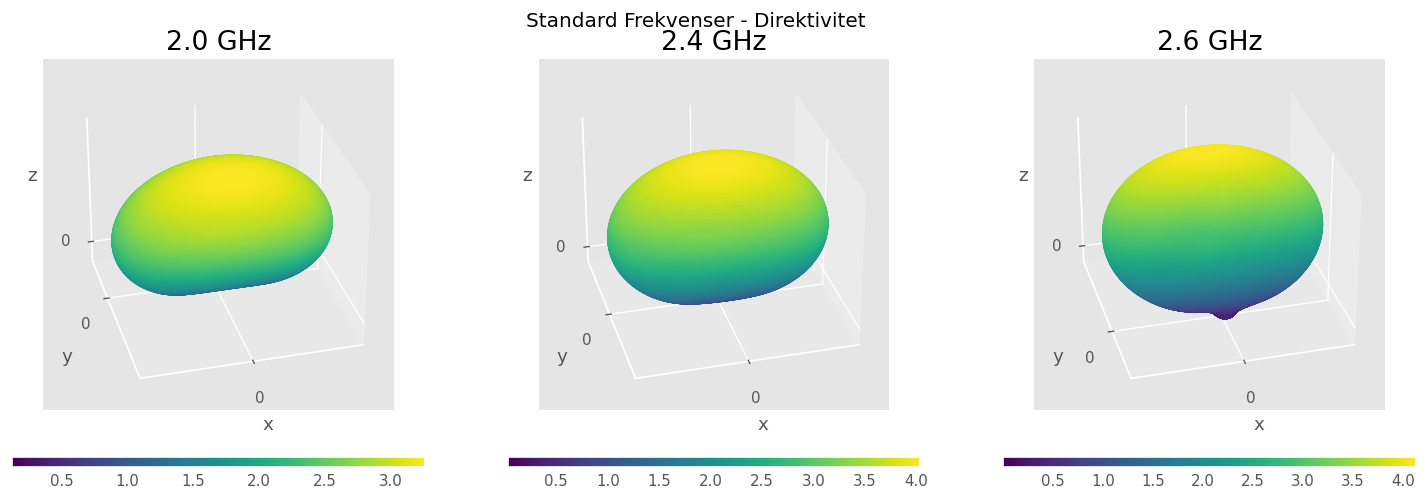

In [225]:
# Plotting av 3D strålingsmønster for standard-frekvenser
fig = plt.figure(figsize=(15, 5))

for i, (freq, data) in enumerate(datasets_standard.items(), 1):
    ax = fig.add_subplot(1, len(datasets_standard), i, projection='3d')
    
    theta = np.radians(data["Theta [deg.]"])
    phi = np.radians(data["Phi [deg.]"])
    r = 10**(data["Abs(Dir.)[dBi]"]/10)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    sc = ax.scatter(x, y, z, c=r, cmap='viridis', marker='o')
    fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.1, aspect=40)
    ax.set_title(f"{freq}")
    ax.view_init(elev=30, azim=75)

    ax.set_xticks([0])
    ax.set_yticks([0])
    ax.set_zticks([0])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.suptitle("Standard Frekvenser - Direktivitet")
plt.show()

### Array

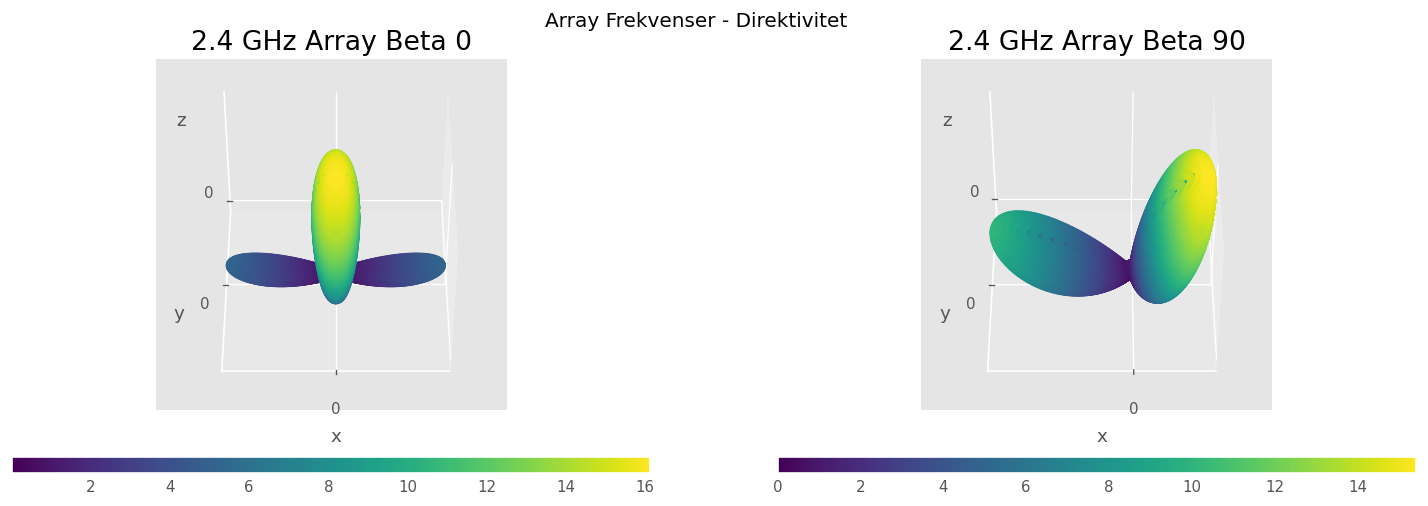

In [226]:
# Plotting av 3D strålingsmønster for array-frekvenser
fig = plt.figure(figsize=(15, 5))

for i, (freq, data) in enumerate(datasets_array.items(), 1):
    ax = fig.add_subplot(1, len(datasets_array), i, projection='3d')
    
    theta = np.radians(data["Theta [deg.]"])
    phi = np.radians(data["Phi [deg.]"])
    r = 10**(data["Abs(Dir.)[dBi]"]/10)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    sc = ax.scatter(x, y, z, c=r, cmap='viridis', marker='o')
    fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.1, aspect=40)
    ax.set_title(f"{freq}")
    ax.view_init(elev=45, azim=90)

    ax.set_xticks([0])
    ax.set_yticks([0])
    ax.set_zticks([0])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.suptitle("Array Frekvenser - Direktivitet")
plt.show()